dt vs rf vs gb: https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained
     rf hyper tune: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
partial dependency: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py


# Load data from csv files

In [150]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [151]:
# Read data from csv files
label = pd.read_csv('BurnedArea-100k.csv')
elevation = pd.read_csv('Elevation-100k.csv')
forest = pd.read_csv('Forest-100k.csv')
humanMod = pd.read_csv('HumanModification-100k.csv')
leaf = pd.read_csv('LeafArea-100k.csv')
rain = pd.read_csv('Precipitation-100k.csv')
radiation = pd.read_csv('Radiation-100k.csv')
soil = pd.read_csv('SoilType-100k.csv')
temp = pd.read_csv('Temperature-100k.csv')

In [4]:
# Merge all dataframes via inner join
samples = pd.merge(left=elevation, right=forest, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=humanMod, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=leaf, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=rain, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=radiation, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=soil, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=temp, left_on='system:index', right_on='system:index')

fireIdx = label.copy()
del fireIdx['BurnDate']
del fireIdx['FirstDay']
del fireIdx['LastDay']
del fireIdx['QA']
del fireIdx['BurnMonth']

In [6]:
# Label samples
samplesCopy = samples.copy()
samplesCopy = pd.merge(left=fireIdx, right=samplesCopy, how='right', left_on='system:index', right_on='system:index')

sampleLabel = samplesCopy['Uncertainty'].fillna(100).tolist()
firstNoFireIdx = sampleLabel.index(100)

# Drop label column
del samplesCopy['Uncertainty']
# Drop system index
del samplesCopy['system:index']
samplesList = samplesCopy.values.tolist()
# Filter out fire samples
fireSamples = samplesList[:firstNoFireIdx]
fireUncertain = sampleLabel[:firstNoFireIdx]
# Filter out no fire samples
noFireSamples = samplesList[firstNoFireIdx:]
noFireLabel = [0 for _ in range(len(noFireSamples))]

# Split the training datasets
X_train_fire, X_test_fire, y_train_fire, y_test_fire = train_test_split(fireSamples, fireUncertain, test_size=0.2, random_state=0)
X_train_nofire, X_test_nofire, y_train_nofire, y_test_nofire = train_test_split(noFireSamples, noFireLabel, test_size=0.9, random_state=42)

# Relabling for binary classification
y_train_fire_bool = [1 for _ in range(len(y_train_fire))]
y_test_fire_bool = [1 for _ in range(len(y_test_fire))]
X_train = X_train_fire + X_train_nofire
y_train = y_train_fire_bool + y_train_nofire

# Binary Classification

## Decision Tree

In [93]:
# 'class_weight': {0: 1.5, 1: 8.5}, 'max_depth': 2, 'max_features': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 0.3
# Specify class_weight to adjust bias
dt_fnf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.2, min_samples_leaf=5, max_features=0.1, class_weight={0:1.5, 1:8.5}, random_state=20)
dt_fnf = dt_fnf.fit(X_train, y_train)

y_pred_fire_bool = dt_fnf.predict(X_test_fire)
print('fire prediction: ', np.mean(y_test_fire_bool == y_pred_fire_bool))
y_no_fire_pred = dt_fnf.predict(X_test_nofire)
print('nofire prediction: ', np.mean(y_no_fire_pred == y_test_nofire))

fire prediction:  0.7298578199052133
nofire prediction:  0.7174368573983013


In [33]:
param_grid = {'max_depth': [2, 4, 6],
              'min_samples_split': [0.3, 0.1, 0.05, 0.02],
              'min_samples_leaf': [1, 3, 5, 7, 9, 17],
              'max_features': [1.0, 0.3, 0.1, 0.05],
              'class_weight': [{0:0.8, 1:9.2}, {0:1.1, 1:8.9}, {0:1.3, 1:8.7}, {0:1.5, 1:8.5}]}
est = DecisionTreeClassifier()
gs_cv = GridSearchCV(est, param_grid, cv=5).fit(X_train, y_train)
# Pinrt out the best parameters
print(gs_cv.best_params_)

{'class_weight': {0: 1.5, 1: 8.5}, 'max_depth': 2, 'max_features': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 0.3}


## Random Forest

In [64]:
# Train RandomForest
rf_fnf = RandomForestClassifier(n_estimators=300, max_features=19, max_leaf_nodes=390, max_depth=20, min_samples_leaf=1, min_samples_split=3, random_state=20, n_jobs=-1)
rf_fnf = rf_fnf.fit(X_train, y_train)

y_pred_fire_bool = rf_fnf.predict(X_test_fire)
print('fire prediction: ', np.mean(y_test_fire_bool == y_pred_fire_bool))
y_no_fire_pred = rf_fnf.predict(X_test_nofire)
print('nofire prediction: ', np.mean(y_no_fire_pred == y_test_nofire))

fire prediction:  0.7535545023696683
nofire prediction:  0.9923865668305767


## Gradient Boosting

In [173]:
# estimators 3000: learning_rate=0.1,max_depth=8,max_features=0.3,min_samples_leaf=17,
# estimators 5000: learning_rate=0.02,max_depth=6,max_features=0.1,min_samples_leaf=9,  -- fire prediction:  0.8341232227488151  nofire prediction:  0.99159029950827
gb_fnf = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.1, max_depth=8, max_features=0.3, min_samples_leaf=17, random_state=20)
gb_fnf = gb_fnf.fit(X_train, y_train)

y_pred_fire_bool = gb_fnf.predict(X_test_fire)
print('fire prediction: ', np.mean(y_test_fire_bool == y_pred_fire_bool))
y_no_fire_pred = gb_fnf.predict(X_test_nofire)
print('nofire prediction: ', np.mean(y_no_fire_pred == y_test_nofire))

fire prediction:  0.8341232227488151
nofire prediction:  0.9913528162717926


## FnF Importance Distribution

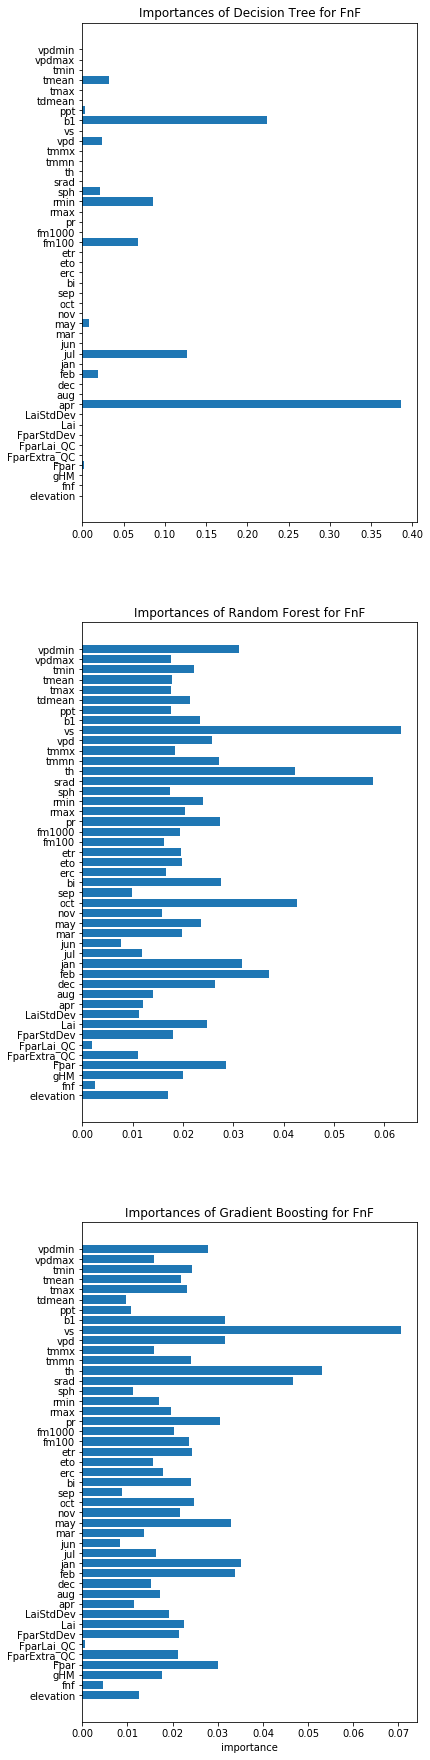

In [176]:
fnf_features = samplesCopy.columns
y_pos = np.arange(len(fnf_features))

fig = plt.figure()

dt_fnf_importances = dt_fnf.feature_importances_
ax1 = fig.add_subplot(311)
ax1.barh(y_pos, dt_fnf_importances)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(fnf_features)
ax1.set_title('Importances of Decision Tree for FnF')

rf_fnf_importances = rf_fnf.feature_importances_
ax2 = fig.add_subplot(312)
ax2.barh(y_pos, rf_fnf_importances)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(fnf_features)
ax2.set_title('Importances of Random Forest for FnF')

gb_fnf_importances = gb_fnf.feature_importances_
ax3 = fig.add_subplot(313)
ax3.barh(y_pos, gb_fnf_importances)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(fnf_features)
ax3.set_title('Importances of Gradient Boosting for FnF')
ax3.set(xlabel='importance')


plt.subplots_adjust(bottom=.1, top=6)
plt.show()

## FnF Partial Dependencies

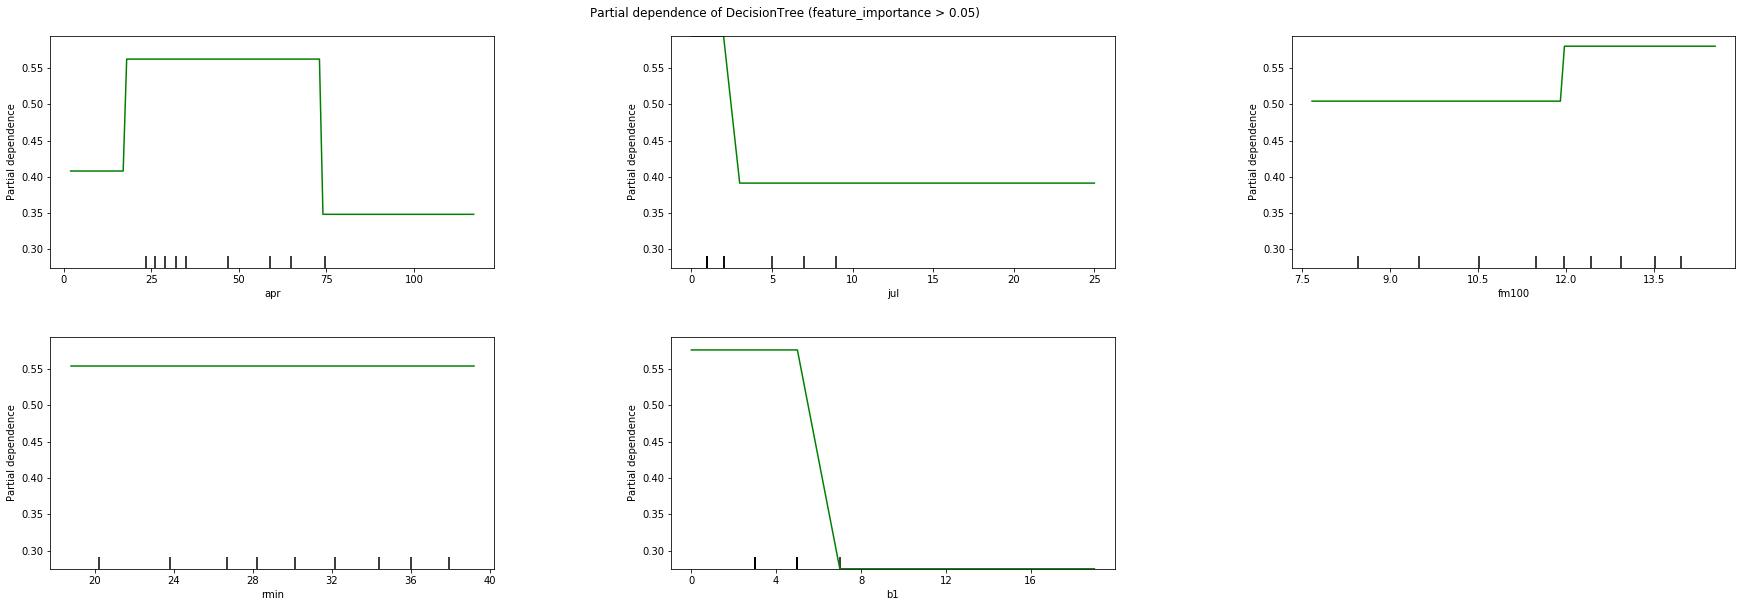

In [116]:
# 9, 14, 25, 29, 37
plot_partial_dependence(dt_fnf, X=X_train_fire, features=[9, 14, 25, 29, 37], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of DecisionTree (feature_importance > 0.05)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

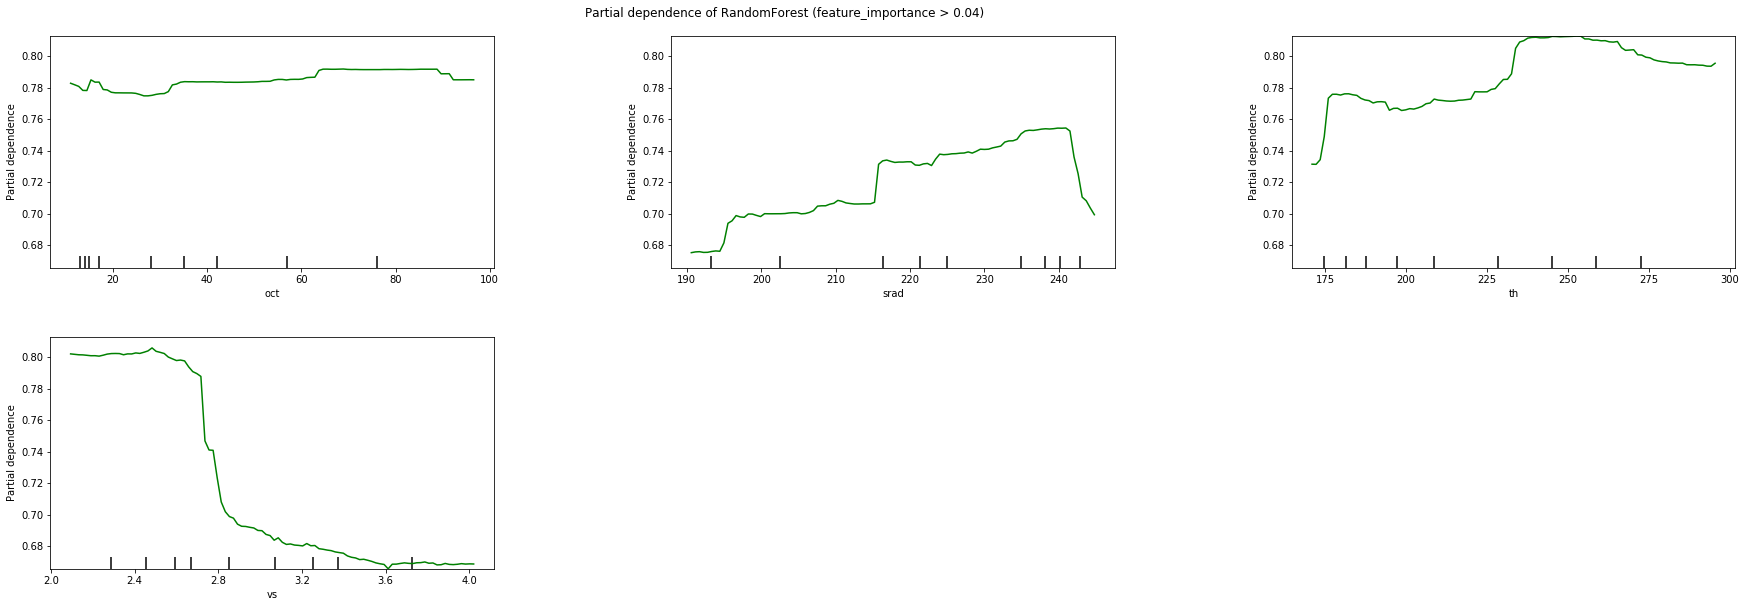

In [113]:
# 19, 31, 32, 36
# Prediction is very slow
plot_partial_dependence(rf_fnf, X=X_train_fire, features=[19, 31, 32, 36], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.04)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

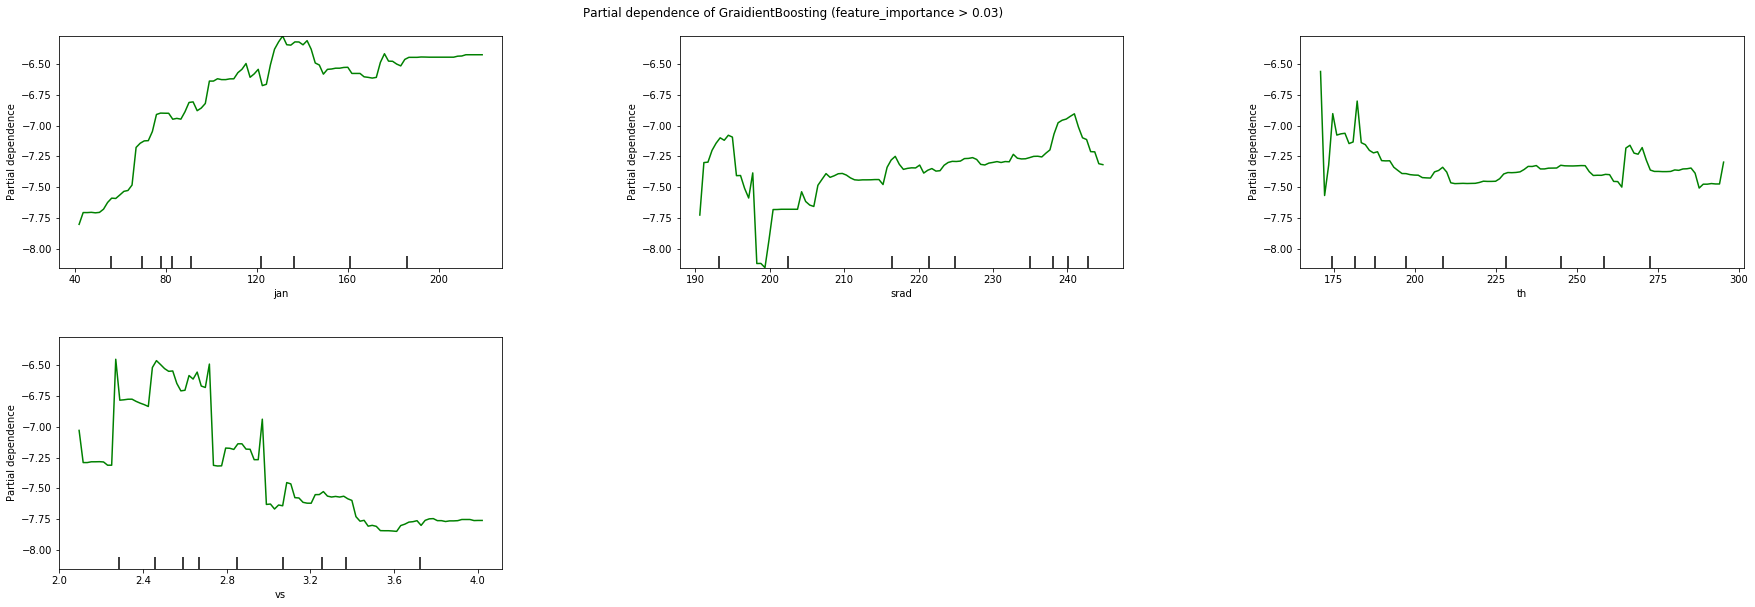

In [179]:
# 12, 13, 32, 35, 36, 41
plot_partial_dependence(gb_fnf, X=X_train_fire, features=[13, 31, 32, 36], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of GraidientBoosting (feature_importance > 0.035)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

In [178]:
for i, _ in enumerate(gb_fnf.feature_importances_):
    if _ > 0.035:
        print(i)

13
31
32
36


# Confusion Matrix for Binary Classification

In [183]:
print(y_pred_fire_bool)

[0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1]


<class 'numpy.ndarray'>


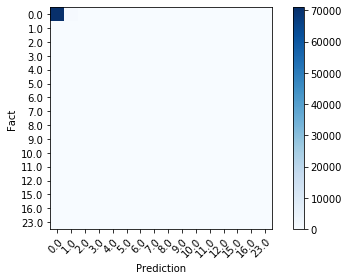

In [181]:
yy_test = y_test_fire + y_test_nofire
#rint(yy_test)
print(type(y_pred_fire_bool))
yy_pred = np.append(y_pred_fire_bool, y_no_fire_pred)
cm = confusion_matrix(yy_test, yy_pred)

# Only uses the labels that appear in the data
labels = unique_labels(yy_test, yy_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

# Multi-Classification

## Decision Tree

In [61]:
dt_risk = DecisionTreeClassifier(max_depth=6, min_samples_split=0.3, min_samples_leaf=5, max_features=0.2, random_state=20)
dt_risk = dt_risk.fit(X_train_fire, y_train_fire)

y_fire_pred_multi = dt_risk.predict(X_test_fire)
print('Exact accuracy', np.mean((y_test_fire == y_fire_pred_multi) * y_pred_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_fire_pred_multi[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print('Accuracy diff < 6: ', np.mean(result * y_pred_fire_bool))

Exact accuracy 0.2559241706161137
Accuracy diff < 6:  0.6587677725118484


In [60]:
param_grid = {'max_depth': [2, 4, 6],
              'min_samples_split': [0.3, 0.1, 0.05, 0.02],
              'min_samples_leaf': [1, 3, 5, 7, 9, 17],
              'max_features': [1.0, 0.3, 0.1, 0.05]}
est = DecisionTreeClassifier()
gs_cv = GridSearchCV(est, param_grid, cv=5).fit(X_train_fire, y_train_fire)
# Pinrt out the best parameters
print(gs_cv.best_params_)

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 0.02}


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Random Forest

In [117]:
rf_risk = RandomForestClassifier(n_estimators=100, max_features=38, max_depth=2, random_state=20, n_jobs=-1)
rf_risk = rf_risk.fit(X_train_fire, y_train_fire)
y_fire_pred_multi = rf_risk.predict(X_test_fire)
print(np.mean((y_test_fire == y_fire_pred_multi) * y_pred_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_fire_pred_multi[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_fire_bool))
#np.mean(result)

0.26066350710900477
0.6729857819905213


## Gradient Boosting

In [152]:
# estimator 3000: learning_rate=0.02,max_depth=6,max_features=0.05,min_samples_leaf=5
gb_risk = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.02,max_depth=6,max_features=0.05,min_samples_leaf=5,random_state=20)
gb_risk = gb_risk.fit(X_train_fire, y_train_fire)
y_pred_fire_risk = gb_risk.predict(X_test_fire)
print(np.mean((y_test_fire == y_pred_fire_risk) * y_pred_fire_bool))
#np.mean(result)
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_fire_risk[i]) < 4:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_fire_bool))

0.33175355450236965
0.6303317535545023


## Fire Risk Importance Distribution

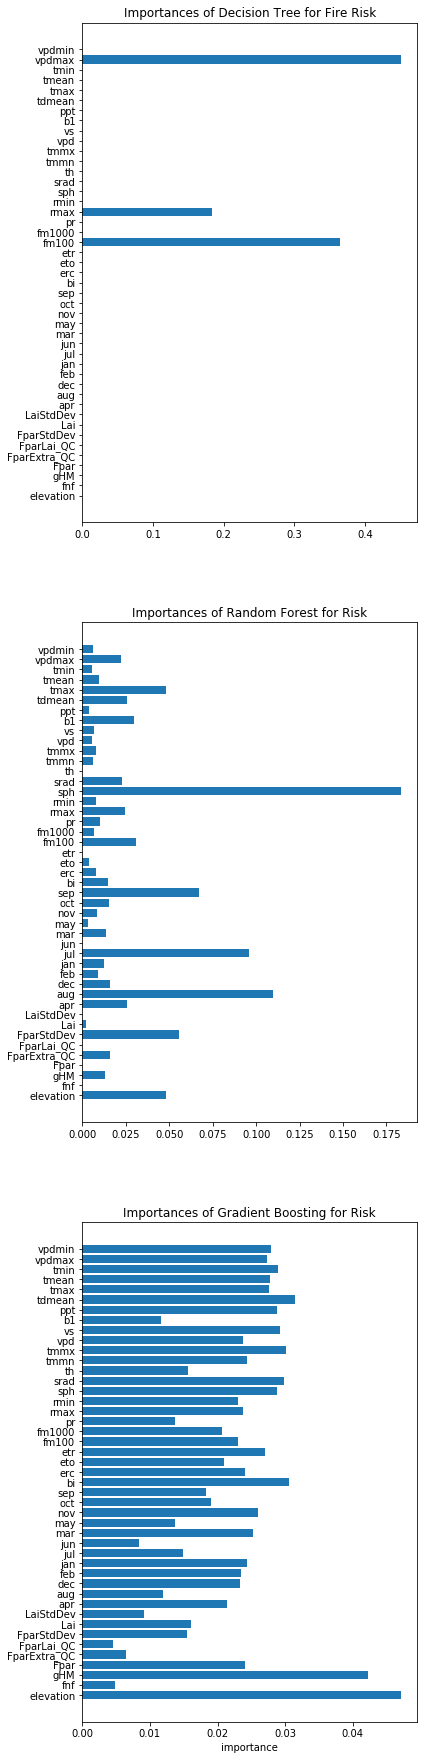

In [119]:
risk_features = samplesCopy.columns
y_pos = np.arange(len(risk_features))

fig = plt.figure()

dt_risk_importances = dt_risk.feature_importances_
ax1 = fig.add_subplot(311)
ax1.barh(y_pos, dt_risk_importances)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(risk_features)
ax1.set_title('Importances of Decision Tree for Fire Risk')

rf_risk_importances = rf_risk.feature_importances_
ax2 = fig.add_subplot(312)
ax2.barh(y_pos, rf_risk_importances)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(risk_features)
ax2.set_title('Importances of Random Forest for Risk')

gb_risk_importances = gb_risk.feature_importances_
ax3 = fig.add_subplot(313)
ax3.barh(y_pos, gb_risk_importances)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(risk_features)
ax3.set_title('Importances of Gradient Boosting for Risk')
ax3.set(xlabel='importance')


plt.subplots_adjust(bottom=.1, top=6)
plt.show()

## Fire Risk Partial Dependencies

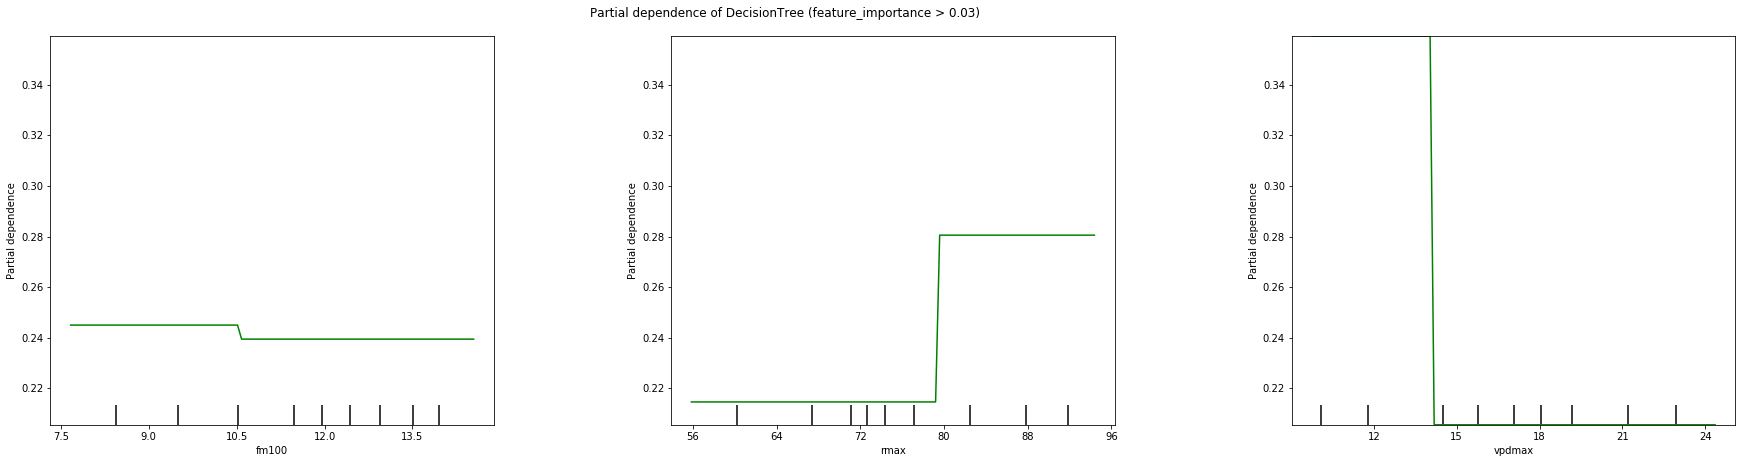

In [141]:
plot_partial_dependence(dt_risk, X=X_train_fire, features=[25, 28, 43], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of DecisionTree (feature_importance > 0.1, target=3)', x=1.8, y=1.6)
plt.subplots_adjust(top=1.5, right=4)

(array([57., 60., 35., 17., 13., 10.,  3.,  5.,  1.,  3.,  2.,  1.,  0.,
         0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <a list of 22 Patch objects>)

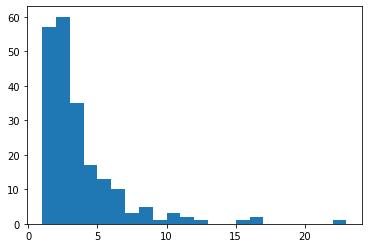

In [158]:
#plt.hist(y_train_fire, bins=np.arange(min(y_train_fire), max(y_train_fire)+1), align='mid')
#plt.hist(y_pred_fire_risk, bins=np.arange(min(y_pred_fire_risk), max(y_pred_fire_risk)+1), align='mid')
plt.hist(y_test_fire, bins=np.arange(min(y_test_fire), max(y_test_fire)+1), align='mid')

(array([71., 65., 28., 18., 16.,  5.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.]),
 <a list of 18 Patch objects>)

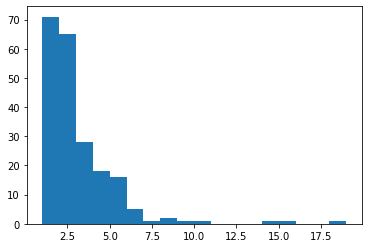

In [159]:
#plt.hist(y_train_fire, bins=np.arange(min(y_train_fire), max(y_train_fire)+1), align='mid')
plt.hist(y_pred_fire_risk, bins=np.arange(min(y_pred_fire_risk), max(y_pred_fire_risk)+1), align='mid')
#plt.hist(y_test_fire, bins=np.arange(min(y_test_fire), max(y_test_fire)+1), align='mid')

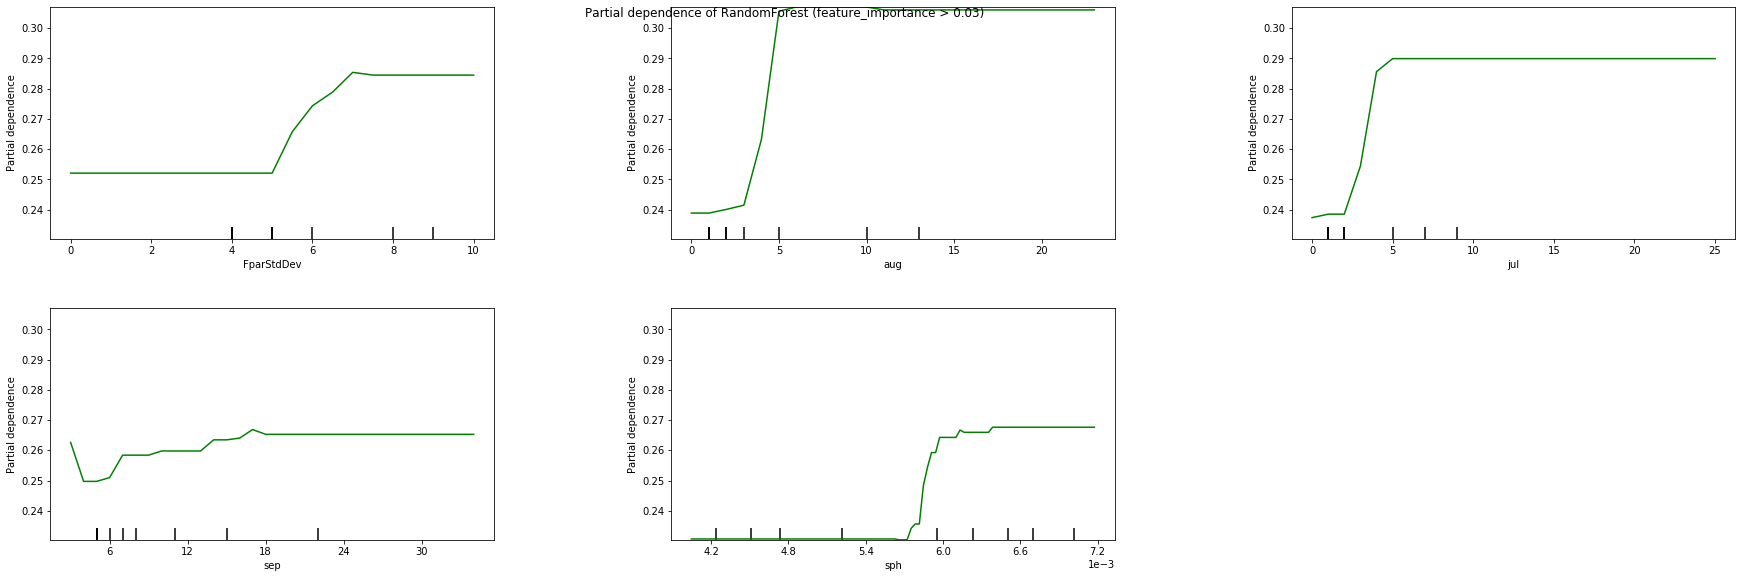

In [145]:
plot_partial_dependence(rf_risk, X=X_train_fire, features=[6, 10, 14, 20, 30], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.04, target=3)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

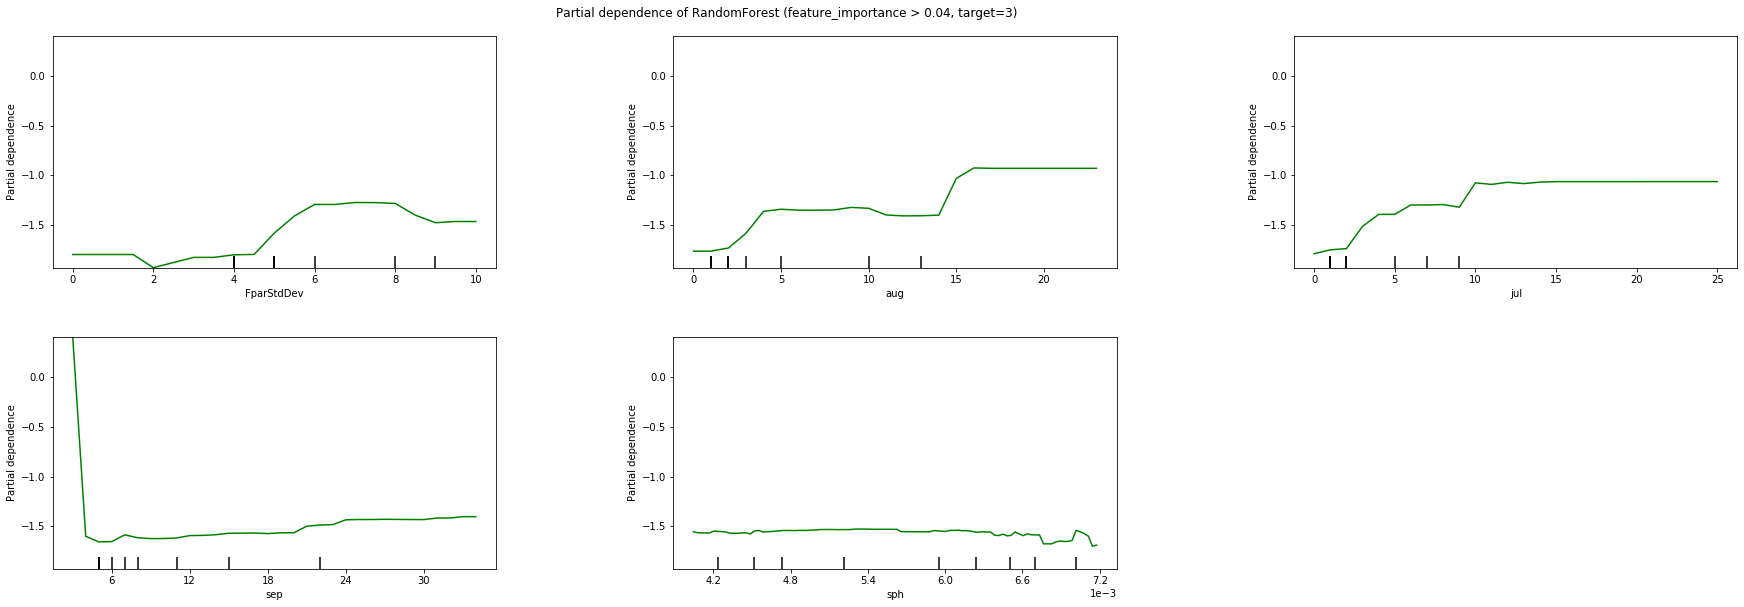

In [149]:
plot_partial_dependence(gb_risk, X=X_train_fire, features=[6, 10, 14, 20, 30], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.03, target=3)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

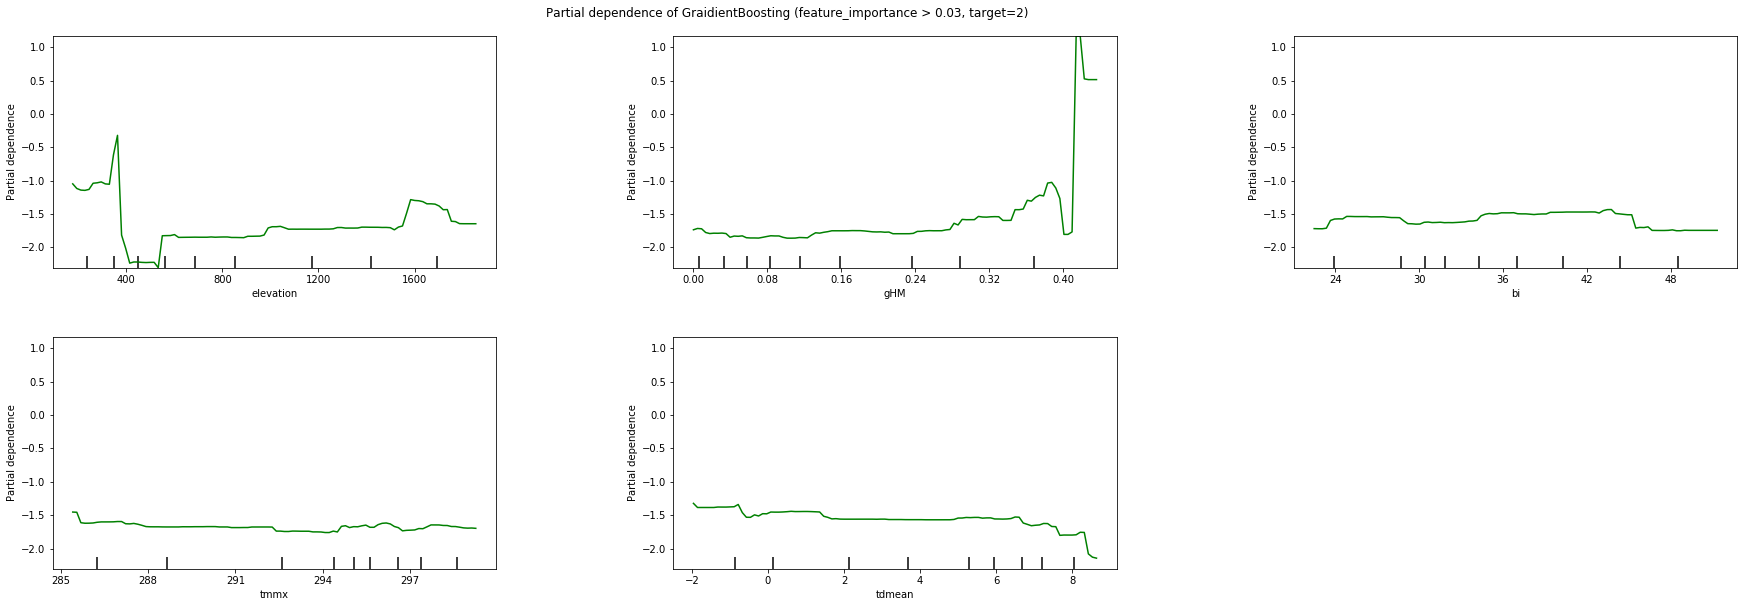

In [148]:
plot_partial_dependence(gb_risk, X=X_train_fire, features=[0, 2, 21, 34, 39], target=2, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of GraidientBoosting (feature_importance > 0.03, target=2)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

In [146]:
ws = list(zip(samplesCopy.columns, gb_risk.feature_importances_))
ws
for i, _ in enumerate(ws):
    if _[1] > 0.03:
        print(i)

0
2
21
34
39


# Confusion Matrix for Multi-Classification

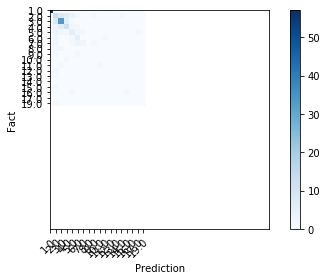

In [170]:
y_test_multi = y_test_fire * y_pred_fire_bool
y_pred_multi = y_pred_fire_risk * y_pred_fire_bool
cm = confusion_matrix(y_test_multi, y_pred_multi)

# Only uses the labels that appear in the data
labels = unique_labels(fireUncertain)


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), # ... and label them with the respective list entries
       xlim=[0.0, 40.0], ylim=[40.0, 0.0],
       xticklabels=labels, yticklabels=labels,
       xlabel='Prediction', ylabel='Fact',)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

# Metrics

In [120]:
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71584
           1       0.22      0.75      0.34       211

    accuracy                           0.99     71795
   macro avg       0.61      0.87      0.67     71795
weighted avg       1.00      0.99      0.99     71795

